In [1]:
import fiona
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show as rioshow
from rasterio import transform
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import LineString
from shapely.geometry import box
from shapely import wkt
from pyproj import Transformer

import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from dotenv import load_dotenv

np.set_printoptions(suppress=True)

In [2]:
# Enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['libkml'] = 'rw'
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

## Variables

In [3]:
# Load environmaent variable
load_dotenv()

True

In [4]:
geoCRS = 4326  # for output GeoJSON files (lon/lat)
projCRS = 3857  # for calculations (meters)
OPENTOPO_TOKEN = os.getenv('OPENTOPO_TOKEN')

## Initial Data Analysis

### Area of Interest

In [5]:
# Store file path
kreminna_aoi_file = os.path.join('assets','geom','kreminna.kml')

In [6]:
# Read and display the area of interest
kreminna_aoi = gpd.read_file(kreminna_aoi_file).to_crs(projCRS)
print(kreminna_aoi.crs)
kreminna_aoi

EPSG:3857


,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,Kreminna,None,NaT,NaT,NaT,None,-1,0,-1,None,None,"POLYGON Z ((4225475.440 6244152.071 0.000, 424..."


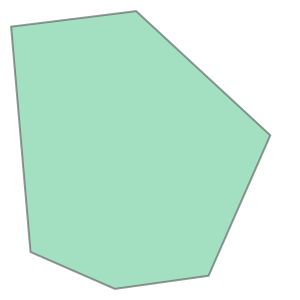

In [7]:
kreminna_aoi.iloc[0,-1]

In [8]:
# Remove z coordinate
kreminna_aoi['geometry'] = kreminna_aoi['geometry'].apply(lambda g: wkt.loads(wkt.dumps(g, output_dimension=2)))
kreminna_aoi

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,Kreminna,None,NaT,NaT,NaT,None,-1,0,-1,None,None,"POLYGON ((4225475.440 6244152.071, 4248819.565..."


In [9]:
# Remove unnecessary columns and rename one
kreminna_aoi = kreminna_aoi[['Name','geometry']].rename(columns={'Name':'name'})

In [10]:
# Export area of interest
kreminna_aoi.to_crs(geoCRS).to_file('kreminna-clipped-aoi.geojson', driver='GeoJSON')

### Digital Elevation Model (DEM)

In [11]:
# Box coordinates: west, south, east, north
# kreminna_aoi.bounds

In [12]:
# Download Digital Elevation Model for the area (free API token at https://portal.opentopography.org/ is required)

# w, s, e, n = kreminna_aoi.to_crs(geoCRS).bounds.minx, kreminna_aoi.bounds.miny, kreminna_aoi.bounds.maxx, kreminna_aoi.bounds.maxy

# url = "https://portal.opentopography.org/API/globaldem"

# params = {
#     'demtype': 'SRTMGL1',
#     'south': s,
#     'north': n,
#     'west': w,
#     'east': e,
#     'outputFormat': 'GTiff',
#     'API_Key': OPENTOPO_TOKEN
# }

# response = requests.get(url, params=params)

# with open ('kreminna-DEM.tif', 'wb') as f:
#     f.write(response.content)

In [13]:
# Store file path
kreminna_dem_file = 'kreminna-DEM.tif'

In [14]:
# Read file contents
with rio.open(kreminna_dem_file) as f:
    print(f.meta)
    kreminna_dem_array = f.read(1)  # number of band (single here anyways)
    kreminna_dem_transform = f.transform
    kreminna_dem_crs = f.crs

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 2321, 'height': 1632, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777778146, 0.0, 37.90958333336221,
       0.0, -0.0002777777777778146, 49.21180555555413)}


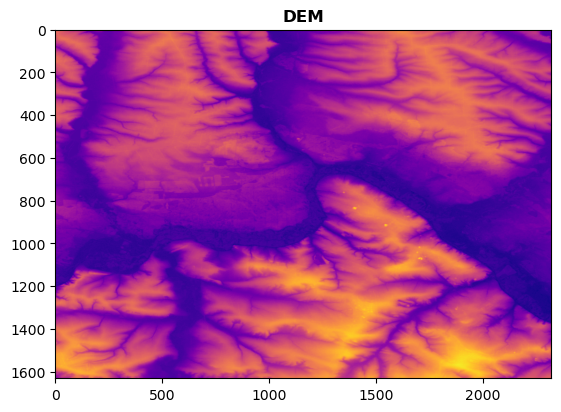

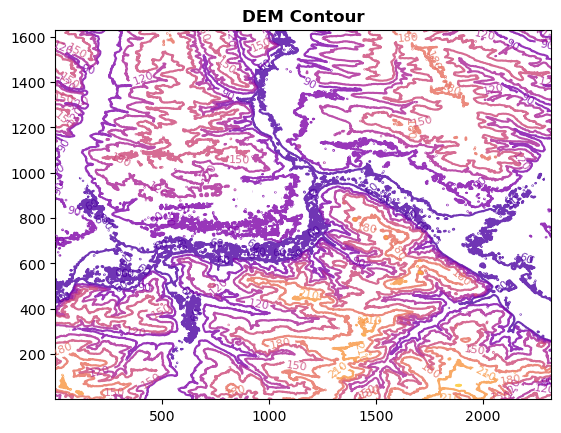

(<Axes: title={'center': 'DEM'}>, <Axes: title={'center': 'DEM Contour'}>)

In [15]:
# Show dem and contours
rioshow(kreminna_dem_array, cmap='plasma', title='DEM'), rioshow(kreminna_dem_array, cmap='plasma', title='DEM Contour', contour=True)

#### DEM to Contour in QGIS (+Smoothing)

The contour will be used later for the final visualization.

After importing the downloaded DEM the contours were modified. With the help of __"Generalizer"__ tool, most small objects present on the contour were removed (__"Remove small objects"__ algorithm). After that, the __"Boyle's Forward-Looking Algorithm"__ was used for line smoothing.  

Before<br>
<img src="assets/kreminna/kreminna-qgis-contour-raw.png" alt="w" width="700"/><br>

After<br>
<img src="assets/kreminna/kreminna-qgis-contour-smooth.png" alt="w" width="700"/><br>

In [16]:
# Store file path
kreminna_contour_file = os.path.join('assets','elevation','kreminna-elevation-contour.geojson')

EPSG:3857


<Axes: >

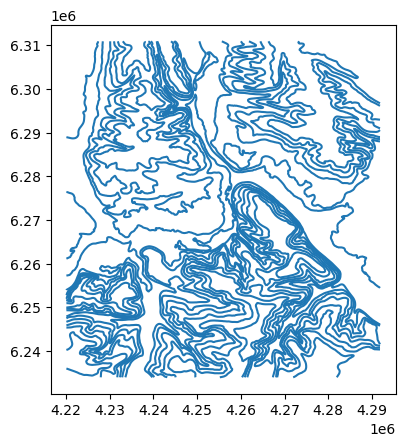

In [17]:
# Read and display data
kreminna_contour = gpd.read_file(kreminna_contour_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(kreminna_contour.crs)
kreminna_contour.plot()

In [18]:
kreminna_contour.head()

,fid,ID,ELEV,geometry
0,372,371,160.0,"LINESTRING (4237994.859 6310877.081, 4238001.1..."
1,499,498,60.0,"LINESTRING (4249528.795 6299548.041, 4249536.3..."
2,543,542,140.0,"LINESTRING (4244024.664 6310877.081, 4244044.8..."
3,581,580,120.0,"LINESTRING (4244622.491 6310877.081, 4244641.5..."
4,694,693,160.0,"LINESTRING (4239479.119 6295058.480, 4239470.9..."


In [19]:
# Remove unnecessary columns and rename one
kreminna_contour = kreminna_contour[['ELEV','geometry']].rename(columns={'ELEV':'elevation'})

<Axes: >

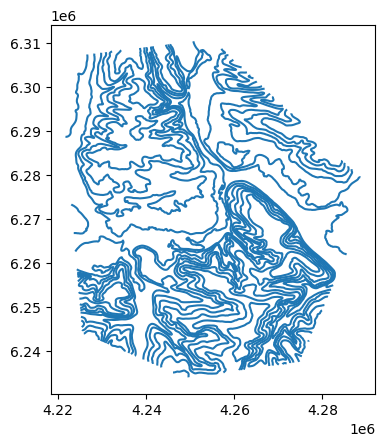

In [20]:
# Check contours clip
kreminna_contour.clip(kreminna_aoi).plot()

In [21]:
# Export clipped contour
kreminna_contour.clip(kreminna_aoi, keep_geom_type=True).to_crs(geoCRS).to_file('kreminna-clipped-contours.geojson', driver='GeoJSON')

### Occupied Area

Some data cleaning and export as GeoJSON conducted using __[geojson.io](https://geojson.io/#map=2/0/20)__

__Before__: single file with different geometries

<img src="assets/kreminna/warzone-160624-geojson.io.png" alt="w" width="500"/><br>

__After__: 2 separate files, for areas (polygons) and fortifications (lines)

<img src="assets/kreminna/occupied-areas-160624-geojson.io.png" alt="oa" width="500"/><img src="assets/kreminna/fortification-lines-160624-geojson.io.png" alt="fl" width="500"/>

In [22]:
# Store file path
warzone_output = os.path.join('assets','osint','occupied-areas-160624.geojson')

EPSG:3857


<Axes: >

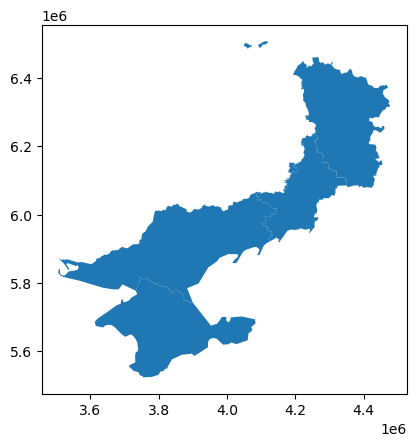

In [23]:
# Read and display data
warzone_areas = gpd.read_file(warzone_output).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_areas.crs)
warzone_areas.plot()

In [24]:
warzone_areas.shape

(12, 2)

In [25]:
warzone_areas

,name,geometry
0,Luhansk Axis,"POLYGON Z ((4260951.436 6236366.452 0.000, 425..."
1,Crimea,"POLYGON Z ((3732416.067 5777376.267 0.000, 373..."
2,Zaporizhia and Kherson Axis [Z],"POLYGON Z ((4081179.821 6062810.207 0.000, 407..."
3,Donetsk Axis,"POLYGON Z ((4189021.991 5957234.538 0.000, 419..."
4,Russian Luhansk/Kharkiv Offensive,"POLYGON Z ((4231127.765 6278584.023 0.000, 423..."
5,Russian Bakhmut Offensive,"POLYGON Z ((4218856.750 6213061.806 0.000, 421..."
6,Russian N Kharkiv Offensive,"POLYGON Z ((4223299.322 6370336.996 0.000, 422..."
7,Russian Marinka Offensive,"POLYGON Z ((4164876.949 6071702.911 0.000, 416..."
8,Russian Avdiivka Offensive,"POLYGON Z ((4200263.645 6136914.705 0.000, 420..."
9,Russian Velyka Novosilka Offensive,"POLYGON Z ((4097783.512 6061066.588 0.000, 409..."


In [26]:
# Remove z coordinate
warzone_areas['geometry'] = warzone_areas['geometry'].apply(lambda g: wkt.loads(wkt.dumps(g, output_dimension=2)))
warzone_areas.head(1)

,name,geometry
0,Luhansk Axis,"POLYGON ((4260951.436 6236366.452, 4259578.756..."


In [27]:
# Combine geometries
warzone_areas_d = gpd.geoseries.GeoSeries([geom for geom in warzone_areas.unary_union.geoms])
warzone_areas_d

0    POLYGON ((3985534.326 5700362.291, 3998375.697...
1    POLYGON ((4069614.549 6495154.014, 4069867.155...
2    POLYGON ((4105818.152 6504715.738, 4109319.707...
dtype: geometry

In [28]:
# Merge all polygons into a single multipolygon
warzone_area = warzone_areas.dissolve().replace('Luhansk Axis', 'occupied')
warzone_area

,geometry,name
0,"MULTIPOLYGON (((3985534.326 5700362.291, 39983...",occupied


<Axes: >

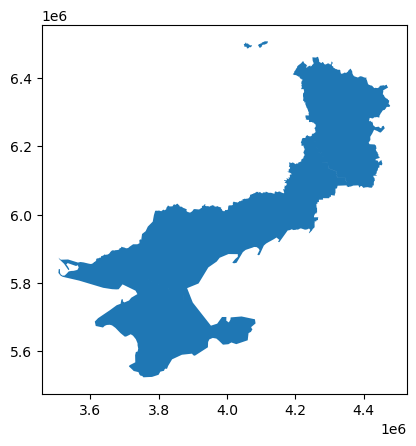

In [29]:
# Display all occupied area
warzone_area.plot()

<Axes: >

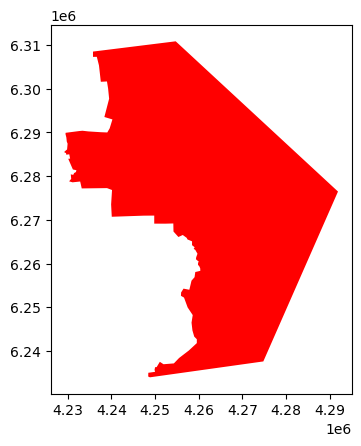

In [30]:
# Display occupied area of interest
warzone_area.clip(kreminna_aoi).plot(color='r')

In [31]:
# Export clipped occupied area
warzone_area.clip(kreminna_aoi, keep_geom_type=True).to_crs(geoCRS).to_file('kreminna-clipped-occupied.geojson', driver='GeoJSON')

### Trenches / Fortifications

In [32]:
# Store file path
warzone_fortif_file= os.path.join('assets','osint','fortification-lines-160624.geojson')

EPSG:3857


<Axes: >

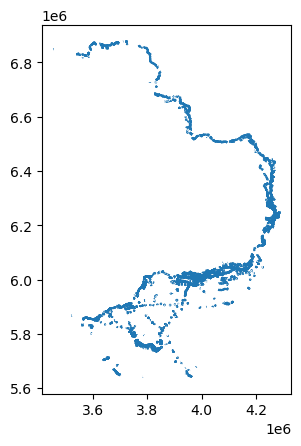

In [33]:
# Read and display data
warzone_fortif = gpd.read_file(warzone_fortif_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_fortif.crs)
warzone_fortif.plot()

In [34]:
warzone_fortif.shape

(18, 6)

In [35]:
warzone_fortif

,name,styleUrl,stroke-opacity,stroke,stroke-width,geometry
0,Trenches Russia,#line-E65100-2000,1,#e65100,2,GEOMETRYCOLLECTION Z (LINESTRING Z (4194947.10...
1,Trenches East,#line-E65100-2000,1,#e65100,2,GEOMETRYCOLLECTION Z (LINESTRING Z (4191602.84...
2,Trenches South,#line-E65100-2000,1,#e65100,2,GEOMETRYCOLLECTION Z (LINESTRING Z (3895406.61...
3,Dragonteeth East,#line-BDBDBD-2000,1,#bdbdbd,2,GEOMETRYCOLLECTION Z (LINESTRING Z (4209115.40...
4,Dragonteeth South,#line-BDBDBD-2000,1,#bdbdbd,2,GEOMETRYCOLLECTION Z (LINESTRING Z (3911153.53...
5,Dragonteeth Russia,#line-BDBDBD-2000,1,#bdbdbd,2,GEOMETRYCOLLECTION Z (LINESTRING Z (3538474.69...
6,Tankditches East,#line-BCAAA4-2000,1,#bcaaa4,2,GEOMETRYCOLLECTION Z (LINESTRING Z (4221277.05...
7,Tankditches South,#line-BCAAA4-2000,1,#bcaaa4,2,GEOMETRYCOLLECTION Z (LINESTRING Z (3902802.45...
8,Tankditch Russia,#line-BCAAA4-2000,1,#bcaaa4,2,GEOMETRYCOLLECTION Z (LINESTRING Z (3537983.66...
9,Trenches Russia,#line-E65100-2000,1,#e65100,2,GEOMETRYCOLLECTION Z (LINESTRING Z (4194947.10...


In [36]:
# Check geometry types
warzone_fortif.geom_type.value_counts()

GeometryCollection    18
Name: count, dtype: int64

In [37]:
# Remove unnecessary columns
warzone_fortif = warzone_fortif.drop(columns=['stroke','stroke-width','stroke-opacity','styleUrl'])

In [38]:
# Check number of rows in 'unpacked' collections of geometries
warzone_fortif.explode(index_parts=False).shape

(22014, 2)

<Axes: >

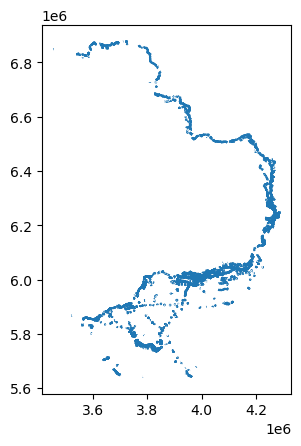

In [39]:
# Store 'unpacked' geometries
warzone_fortif_decomposed = warzone_fortif.explode(ignore_index=True)
warzone_fortif_decomposed.plot()

In [40]:
warzone_fortif_decomposed.tail()

,name,geometry
22009,Tankditch Russia,"LINESTRING Z (4226752.196 6456716.625 0.000, 4..."
22010,Tankditch Russia,"LINESTRING Z (4226767.781 6450343.677 0.000, 4..."
22011,Tankditch Russia,"LINESTRING Z (4234264.369 6439525.504 0.000, 4..."
22012,Tankditch Russia,"LINESTRING Z (4230234.492 6448436.918 0.000, 4..."
22013,Tankditch Russia,"LINESTRING Z (4234265.371 6439521.870 0.000, 4..."


In [41]:
# Remove z coordianate
warzone_fortif_decomposed['geometry'] = warzone_fortif_decomposed['geometry'].apply(lambda g: wkt.loads(wkt.dumps(g, output_dimension=2)))
warzone_fortif_decomposed.head(1)

,name,geometry
0,Trenches Russia,"LINESTRING (4194947.104 6507239.295, 4194669.1..."


In [42]:
# Check fortification types
warzone_fortif_decomposed['name'].value_counts()

name
Trenches South        14940
Trenches East          4626
Trenches Russia         936
Dragonteeth East        370
Tankditch Russia        302
Tankditches South       224
Dragonteeth Russia      220
Tankditches East        206
Dragonteeth South       190
Name: count, dtype: int64

In [43]:
# Keep the fortification type name only
warzone_fortif_decomposed['name'] = warzone_fortif_decomposed['name'].apply(lambda x: x.split()[0])

In [44]:
# Remove use of plural and singular forms of same word
warzone_fortif_decomposed['name'] = warzone_fortif_decomposed['name'].replace('Tankditch','Tankditches')

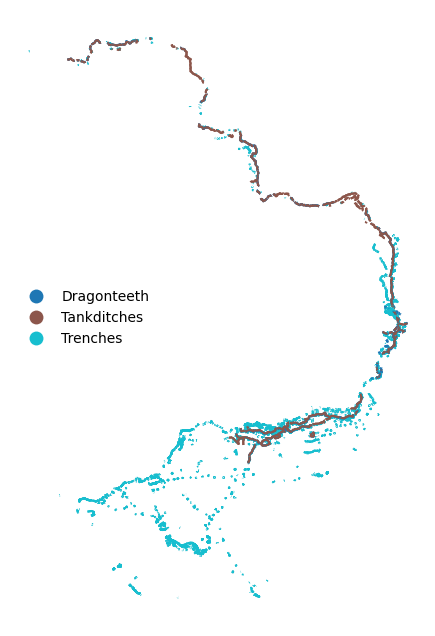

In [45]:
# Plot all available fortifications data
fig, ax = plt.subplots(figsize=(6,8))
warzone_fortif_decomposed.plot(ax=ax, column='name', categorical=True, legend=True, legend_kwds={'loc':'center left', 'frameon':False})
plt.axis('off');

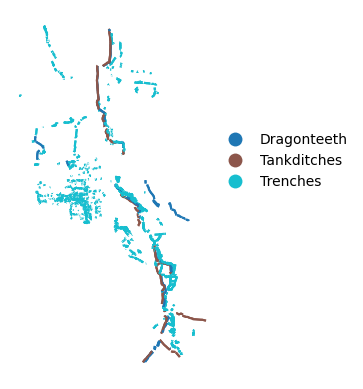

In [46]:
# Plot fortifications data for the area of interest
warzone_fortif_decomposed.clip(kreminna_aoi).plot(column='name', categorical=True, legend=True, legend_kwds={'frameon':False, 'loc':(1,0.5)})
plt.axis('off');

In [47]:
# Create a transformer to convert coordinates from EPSG:3857 to EPSG:4326
transformer = Transformer.from_crs(projCRS, geoCRS)

In [48]:
# Convert the coordinates
x, y = transformer.transform(warzone_fortif_decomposed.centroid.x, warzone_fortif_decomposed.centroid.y)

In [49]:
print('lat:', x[0])
print('lon:', y[0])

lat: 50.350931105034675
lon: 37.681292750770034


In [50]:
# Extract lat and lon into new columns
warzone_fortif_decomposed['lat'] = x
warzone_fortif_decomposed['lon'] = y

In [51]:
warzone_fortif_decomposed.head()

,name,geometry,lat,lon
0,Trenches,"LINESTRING (4194947.104 6507239.295, 4194669.1...",50.350931,37.681293
1,Trenches,"LINESTRING (4200849.932 6494320.785, 4200840.3...",50.274869,37.737546
2,Trenches,"LINESTRING (4201181.330 6494164.018, 4201156.8...",50.275419,37.738600
3,Trenches,"LINESTRING (4200961.919 6493926.436, 4200991.7...",50.274577,37.738953
4,Trenches,"LINESTRING (4221884.195 6459532.421, 4221841.1...",50.076558,37.925507


In [52]:
# Check wsg84 coordinates
warzone_fortif_decomposed.to_crs(geoCRS).head(1)

,name,geometry,lat,lon
0,Trenches,"LINESTRING (37.68385 50.35073, 37.68135 50.351...",50.350931,37.681293


In [53]:
# Export clipped russian positions
warzone_fortif_decomposed.clip(kreminna_aoi, keep_geom_type=True).to_crs(geoCRS).to_file('kreminna-clipped-fortification-lines.geojson', driver='GeoJSON')

### Overpass Turbo Data

Overpass Turbo uses the following format to define a bbox: __miny, minx, maxy, maxx__

In [54]:
# Display area of interest bbox coordinates for overpass turbo query
kreminna_aoi.to_crs(geoCRS).bounds

,minx,miny,maxx,maxy
0,37.909804,48.758341,38.55444,49.211731


Therefore, bbox for current area of interest is: __(48.758341, 37.909804, 49.211731, 38.55444)__ 
***

#### Roads

__Overpass Turbo:__

```
[out:json][timeout:60];

way["highway"](48.758341,37.909804,49.211731,38.55444);

out geom;
```

In [55]:
# Store file path
warzone_roads_file= os.path.join('assets','osint','kreminna-roads.geojson')

EPSG:3857


<Axes: >

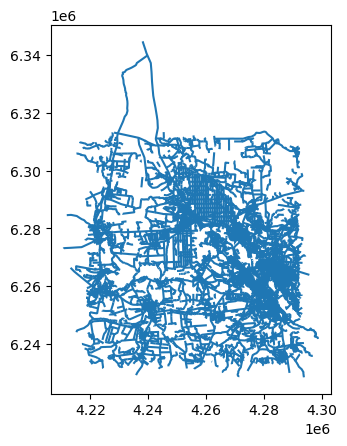

In [56]:
# Read and display data
warzone_roads = gpd.read_file(warzone_roads_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_roads.crs)
warzone_roads.plot()

In [57]:
warzone_roads.columns

Index(['id', '@id', 'access', 'addr:city', 'addr:country', 'addr:postcode',
       'alt_name', 'alt_name:en', 'alt_name:ru', 'alt_name:uk',
       ...
       'tracktype', 'trail_visibility', 'trolley_wire', 'tunnel', 'turn:lanes',
       'type', 'vehicle', 'wheelchair', 'width', 'geometry'],
      dtype='object', length=103)

In [58]:
warzone_roads.iloc[0,:].values

array(['way/58858288', 'way/58858288', None, None, None, None, None, None,
       None, None, 'yes', None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, 'pedestrian', None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, 'Соборна площа', 'Soborna Square',
       None, 'plac Soborny', 'Соборная площадь', 'Соборна площа', None,
       None, None, None, None, None, None, None, None, None, None,
       'square', None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None,
       <POLYGON ((4287435.623 6265004.411, 4287429.133 6264999.343, 4287417.623 626...>],
      dtype=object)

In [59]:
warzone_roads['highway'].value_counts(dropna=False)

highway
service           6292
track             3949
footway           3433
residential       2887
path               904
unclassified       393
tertiary           382
secondary          240
steps              108
primary             99
pedestrian          53
secondary_link      23
raceway             20
tertiary_link       10
living_street        9
cycleway             9
construction         2
primary_link         2
proposed             1
bridleway            1
Name: count, dtype: int64

In [60]:
warzone_roads['highway'].isna().any()

False

In [61]:
# Rename 'highway' column to a more generalized 'road'
warzone_roads = warzone_roads.rename(columns={'highway':'road'})

In [62]:
# Replace None values in 'road' column with 'road' as their new value
warzone_roads['road'] = warzone_roads['road'].fillna('road')

In [63]:
# Filter needed columns
warzone_roads = warzone_roads.loc[:,['id','road','geometry']]
warzone_roads.head(1)

,id,road,geometry
0,way/58858288,pedestrian,"POLYGON ((4287435.623 6265004.411, 4287429.133..."


In [64]:
warzone_roads.isna().any()

id          False
road        False
geometry    False
dtype: bool

In [65]:
# Unpivot a GeoDataFrame
warzone_roads_unpivot = warzone_roads.melt(
    id_vars=['id','geometry'],
    value_vars='road', 
    value_name='sub_category', 
    var_name='category', 
    ignore_index=True
)

warzone_roads_unpivot.head()

,id,geometry,category,sub_category
0,way/58858288,"POLYGON ((4287435.623 6265004.411, 4287429.133...",road,pedestrian
1,way/102843472,"POLYGON ((4284273.838 6267461.078, 4284236.813...",road,footway
2,way/113754362,"POLYGON ((4286856.138 6263917.478, 4286855.704...",road,service
3,way/130398660,"POLYGON ((4285698.705 6264378.217, 4285714.568...",road,pedestrian
4,way/289920731,"POLYGON ((4277104.117 6260010.439, 4277146.953...",road,footway


<Axes: >

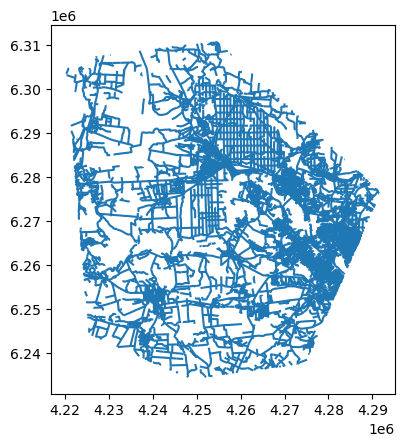

In [66]:
warzone_roads_unpivot.clip(kreminna_aoi).plot()

In [67]:
# Export clipped roads
warzone_roads_unpivot.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-roads.geojson', driver='GeoJSON')

#### Towns, villages, etc

__Overpass Turbo:__

```
[out:json][timeout:60];

node["place"]["place"!~"square"](48.758341,37.909804,49.211731,38.55444);

out geom;

```

In [68]:
# Store file path
warzone_places_file = os.path.join('assets','osint','kreminna-places.geojson')

EPSG:3857


<Axes: >

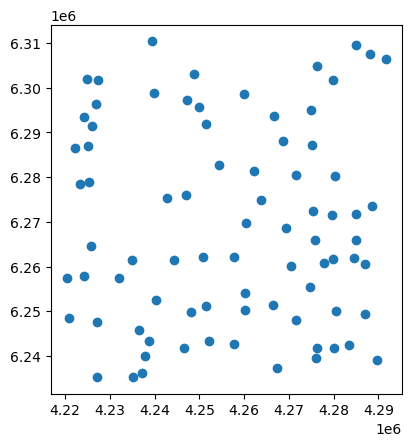

In [69]:
# Read and display data
warzone_places = gpd.read_file(warzone_places_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_places.crs)
warzone_places.plot()

In [70]:
warzone_places.columns

Index(['id', '@id', 'alt_name:cs', 'alt_name:en', 'alt_name:fr', 'alt_name:hr',
       'alt_name:ko', 'attribution', 'contact:website', 'ele', 'katotth',
       'koatuu', 'name', 'name:ar', 'name:ast', 'name:az', 'name:azb',
       'name:ba', 'name:be', 'name:bg', 'name:ca', 'name:ce', 'name:ceb',
       'name:crh', 'name:crh-cyr', 'name:cs', 'name:da', 'name:de', 'name:el',
       'name:en', 'name:eo', 'name:es', 'name:et', 'name:eu', 'name:fa',
       'name:fi', 'name:fr', 'name:he', 'name:hr', 'name:hsb', 'name:hu',
       'name:hy', 'name:it', 'name:ja', 'name:ka', 'name:ko', 'name:ky',
       'name:lt', 'name:lv', 'name:mhr', 'name:ml', 'name:mr', 'name:nl',
       'name:nn', 'name:no', 'name:os', 'name:pl', 'name:prefix', 'name:pt',
       'name:ro', 'name:ru', 'name:rue', 'name:sco', 'name:sr', 'name:sv',
       'name:th', 'name:tr', 'name:tt', 'name:udm', 'name:uk', 'name:uz',
       'name:vep', 'name:vi', 'name:war', 'name:zh', 'note', 'old_name',
       'old_name:be', 'old_na

In [71]:
warzone_places.iloc[0,:].values

array(['node/256614599', 'node/256614599', None, None, None, None, None,
       'travelgps.com.ua', None, None, 'UA14020090340091913',
       '1420980505', 'Виїмка', None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, 'Vyimka',
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, '비임카', None, None, None, None, None, None,
       None, None, None, None, None, 'селище', None, None, 'Выемка', None,
       None, None, None, None, None, None, None, 'Виїмка', None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, 'village', '21', '84541', None,
       None, 'Q4128913', 'uk:Виїмка (селище)', None,
       <POINT (4246573.633 6241774.286)>], dtype=object)

In [72]:
warzone_places['name'].isna().value_counts()

name
False    80
Name: count, dtype: int64

In [73]:
warzone_places['name:en'].isna().value_counts()

name:en
False    76
True      4
Name: count, dtype: int64

In [74]:
# Filter needed columns
warzone_places_filtered = warzone_places.loc[:,['id','name:en','name','place','geometry']]
warzone_places_filtered.head(1)

,id,name:en,name,place,geometry
0,node/256614599,Vyimka,Виїмка,village,POINT (4246573.633 6241774.286)


In [75]:
# Check which english place translations are missing
warzone_places_filtered[warzone_places_filtered['name:en'].isna()]

,id,name:en,name,place,geometry
38,node/337570393,None,Ведмеже,locality,POINT (4239929.830 6298727.955)
77,node/5802076961,None,Матроська,suburb,POINT (4280607.942 6250031.275)
78,node/6549483101,None,Південна,suburb,POINT (4275293.183 6272466.136)
79,node/6835867411,None,Чихирове,suburb,POINT (4289755.900 6239075.091)


In [76]:
# Fill missing place names
warzone_places_filtered.loc[38,'name:en'] = 'Vedmezhe'
warzone_places_filtered.loc[77,'name:en'] = 'Matroska'
warzone_places_filtered.loc[78,'name:en'] = 'Pivdenna'
warzone_places_filtered.loc[79,'name:en'] = 'Chykhyrove'
warzone_places_filtered[warzone_places_filtered['name:en'].isna()]

,id,name:en,name,place,geometry


In [77]:
warzone_places_filtered['place'].value_counts(dropna=False)

place
village     50
town        12
hamlet      10
suburb       4
locality     2
city         2
Name: count, dtype: int64

In [78]:
# Replace None values in 'place' column with 'place' as their new value
warzone_places_filtered['place'] = warzone_places_filtered['place'].fillna('place')

In [79]:
# Create a transformer to convert coordinates from EPSG:3857 to EPSG:4326
transformer = Transformer.from_crs(projCRS, geoCRS)

# Convert the coordinates
x, y = transformer.transform(warzone_places_filtered.centroid.x, warzone_places_filtered.centroid.y)

In [80]:
# Extract lat and lon into new columns
warzone_places_filtered['lat'] = x
warzone_places_filtered['lon'] = y

In [81]:
warzone_places_filtered.isna().any()

id          False
name:en     False
name        False
place       False
geometry    False
lat         False
lon         False
dtype: bool

In [82]:
# Unpivot GeoDataFrame
warzone_places_unpivot = warzone_places_filtered.melt(
    id_vars=['id','name:en','name','lon','lat','geometry'], 
    value_vars='place', 
    value_name='sub_category', 
    var_name='category', 
    ignore_index=True
)

warzone_places_unpivot.sample(10)

,id,name:en,name,lon,lat,geometry,category,sub_category
28,node/337567352,Ploshchanka,Площанка,38.083210,49.208809,POINT (4239403.545 6310366.469),place,village
38,node/337570393,Vedmezhe,Ведмеже,38.087938,49.140459,POINT (4239929.830 6298727.955),place,locality
15,node/256614803,Hryhorivka,Григорівка,38.186420,48.924520,POINT (4250892.830 6262063.708),place,village
50,node/337576644,Rubizhne,Рубіжне,38.372582,49.032905,POINT (4271616.278 6280446.445),place,town
64,node/337582086,Lysychansk,Лисичанськ,38.428598,48.917267,POINT (4277851.972 6260834.976),place,city
47,node/337574994,Stara Krasnianka,Стара Краснянка,38.288593,49.037716,POINT (4262266.676 6281263.435),place,village
17,node/256615981,Terny,Терни,37.962570,49.097210,POINT (4225973.962 6291372.023),place,village
22,node/256616082,Yampil,Ямпіль,37.960105,48.940078,POINT (4225699.570 6264700.062),place,town
7,node/256614688,Kuzmynivka,Кузьминівка,38.069776,48.794228,POINT (4237908.090 6240018.026),place,hamlet
3,node/256614609,Spirne,Спірне,38.247360,48.809420,POINT (4257676.639 6242585.607),place,village


<Axes: >

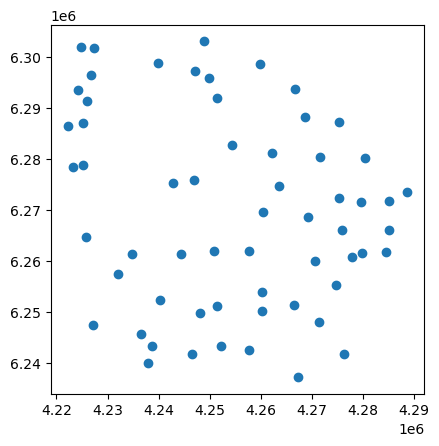

In [83]:
warzone_places_unpivot.clip(kreminna_aoi).plot()

In [84]:
# Export clipped places
warzone_places_unpivot.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-places.geojson', driver='GeoJSON')

#### Buildings

```
[out:json][timeout:60];

nwr["building"](48.758341,37.909804,49.211731,38.55444);

out geom;
```

In [85]:
# Store file path
warzone_buildings_file = os.path.join('assets','osint','kreminna-buildings.geojson')

EPSG:3857


<Axes: >

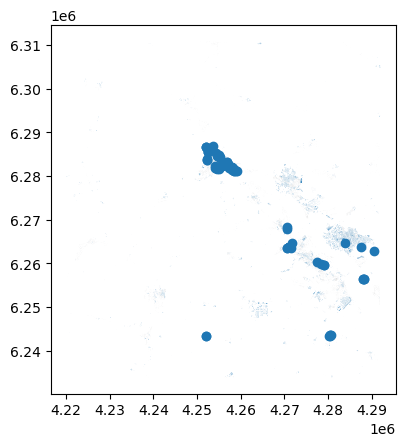

In [86]:
# Read and display data
warzone_buildings = gpd.read_file(warzone_buildings_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_buildings.crs)
warzone_buildings.plot()

In [87]:
# Check geometry types
warzone_buildings.geom_type.value_counts(dropna=False)

Polygon         64314
Point              88
LineString          3
MultiPolygon        2
Name: count, dtype: int64

In [88]:
# Store point geometries instead of polygons
warzone_buildings['geometry'] = warzone_buildings.centroid
warzone_buildings.geom_type.value_counts(dropna=False)

Point    64407
Name: count, dtype: int64

In [89]:
warzone_buildings.columns

Index(['id', '@id', 'abandoned', 'abandoned:building', 'access', 'addr:city',
       'addr:country', 'addr:housenumber', 'addr:postcode', 'addr:street',
       ...
       'tower:type', 'townhall:type', 'train', 'type', 'voltage', 'website',
       'wheelchair', 'wikidata', 'wikipedia', 'geometry'],
      dtype='object', length=141)

In [90]:
warzone_buildings.iloc[0,:].values

array(['relation/1595718', 'relation/1595718', None, None, None, None,
       None, '115а', None, 'Гагаріна вулиця', None, None, None, None,
       None, None, None, None, None, 'kindergarten', None, None, None,
       '2', None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, 'tar_paper',
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, 'multipolygon', None, None, None, None,

In [91]:
warzone_buildings.isna().any()

id                    False
@id                   False
abandoned              True
abandoned:building     True
access                 True
                      ...  
website                True
wheelchair             True
wikidata               True
wikipedia              True
geometry              False
Length: 141, dtype: bool

In [92]:
# Filter needed columns
warzone_buildings_filtered = warzone_buildings.loc[:,['id','geometry']]
warzone_buildings_filtered.head(1)

,id,geometry
0,relation/1595718,POINT (4289358.826 6265648.110)


In [93]:
# Create a transformer to convert coordinates from EPSG:3857 to EPSG:4326
transformer = Transformer.from_crs(projCRS, geoCRS)

# Convert the coordinates
x, y = transformer.transform(warzone_buildings_filtered.centroid.x, warzone_buildings_filtered.centroid.y)

# Extract lat and lon into new columns
warzone_buildings_filtered['lat'] = x
warzone_buildings_filtered['lon'] = y

In [94]:
warzone_buildings_filtered.isna().any()

id          False
geometry    False
lat         False
lon         False
dtype: bool

<Axes: >

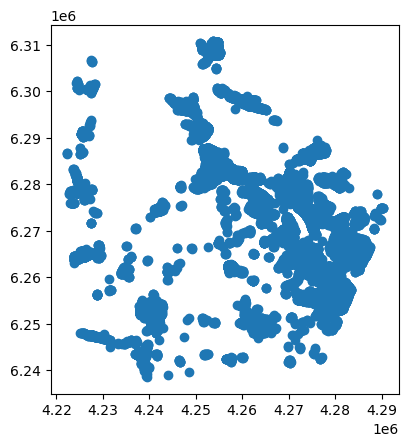

In [95]:
warzone_buildings_filtered.clip(kreminna_aoi).plot()

In [96]:
# Export clipped ponds
warzone_buildings_filtered.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-buildings.geojson', driver='GeoJSON')

#### Lakes, ponds, etc

__Overpass Turbo:__

```
[out:json][timeout:60];

area["natural"="water"]["water"!~"river"](48.758341,37.909804,49.211731,38.55444);

out geom;

```

In [97]:
# Store file path
warzone_ponds_file = os.path.join('assets','osint','kreminna-ponds.geojson')

EPSG:3857


<Axes: >

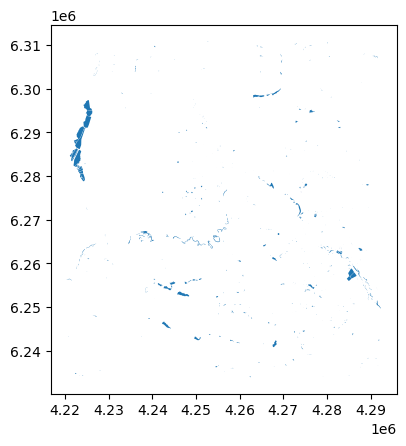

In [98]:
# Read and display data
warzone_ponds = gpd.read_file(warzone_ponds_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_ponds.crs)
warzone_ponds.plot()

In [99]:
warzone_ponds.columns

Index(['id', '@id', 'alt_name', 'amenity', 'description:ru', 'drained',
       'drinking_water', 'intermittent', 'landuse', 'layer', 'liquid_waste',
       'loc_name:ru', 'man_made', 'military', 'name', 'name:en', 'name:ru',
       'name:uk', 'natural', 'reservoir_type', 'salt', 'waste_kind', 'water',
       'geometry'],
      dtype='object')

In [100]:
warzone_ponds.iloc[0,:].values

array(['way/31015582', 'way/31015582', None, None, None, None, None, None,
       None, None, None, None, None, None, 'Чисте озеро', 'Chyste Lake',
       'Чистое озеро', 'Чисте озеро', 'water', None, None, None, 'lake',
       <POLYGON ((4287317.035 6263538.524, 4287291.887 6263523.595, 4287271.327 626...>],
      dtype=object)

In [101]:
warzone_ponds.isna().any()

id                False
@id               False
alt_name           True
amenity            True
description:ru     True
drained            True
drinking_water     True
intermittent       True
landuse            True
layer              True
liquid_waste       True
loc_name:ru        True
man_made           True
military           True
name               True
name:en            True
name:ru            True
name:uk            True
natural           False
reservoir_type     True
salt               True
waste_kind         True
water              True
geometry          False
dtype: bool

In [102]:
warzone_ponds['water'].value_counts(dropna=False)

water
None          463
reservoir     171
pond           93
lake           37
wastewater     16
basin          11
Name: count, dtype: int64

In [103]:
# Replace None values in 'water' column with 'water' as their new value
warzone_ponds['water'] = warzone_ponds['water'].fillna('water')

In [104]:
# Filter needed columns
warzone_ponds = warzone_ponds.loc[:,['id', '@id','water','geometry']]
warzone_ponds.head(1)

,id,@id,water,geometry
0,way/31015582,way/31015582,lake,"POLYGON ((4287317.035 6263538.524, 4287291.887..."


In [105]:
warzone_ponds.isna().any()

id          False
@id         False
water       False
geometry    False
dtype: bool

In [106]:
# Unpivot GeoDataFrame
warzone_ponds_unpivot = warzone_ponds.melt(
    id_vars=['id','geometry'],
    value_vars='water', 
    value_name='sub_category',
    var_name='category', 
    ignore_index=True
)

warzone_ponds_unpivot.sample(10)

,id,geometry,category,sub_category
479,way/387036959,"POLYGON ((4274956.118 6253717.009, 4274942.715...",water,reservoir
198,way/318493865,"POLYGON ((4274502.291 6279345.318, 4274490.948...",water,water
334,way/329270836,"POLYGON ((4236235.003 6266566.885, 4236239.867...",water,lake
191,way/317690580,"POLYGON ((4274136.874 6276183.518, 4274139.111...",water,water
298,way/321739783,"POLYGON ((4251580.283 6293726.699, 4251588.075...",water,water
372,way/344399764,"POLYGON ((4267432.591 6248510.433, 4267417.284...",water,water
160,way/315996023,"POLYGON ((4273927.281 6250693.343, 4273933.226...",water,reservoir
471,way/387036935,"POLYGON ((4275047.957 6253931.323, 4275034.565...",water,reservoir
340,way/330557639,"POLYGON ((4233875.898 6295650.247, 4233828.353...",water,water
677,way/710713918,"POLYGON ((4274648.509 6255156.378, 4274644.613...",water,pond


<Axes: >

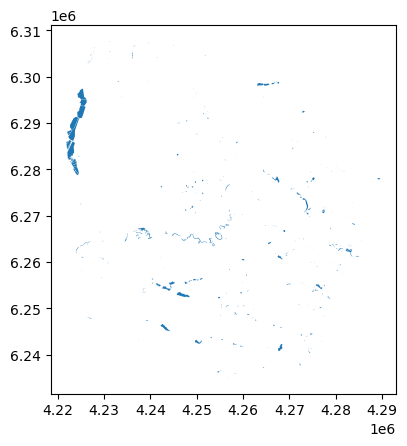

In [107]:
warzone_ponds_unpivot.clip(kreminna_aoi).plot()

In [108]:
# Export clipped ponds
warzone_ponds_unpivot.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-ponds.geojson', driver='GeoJSON')

#### Wetlands, swamps, etc

__Overpass Turbo:__

```
[out:json][timeout:60];

area["natural"="wetland"](48.758341,37.909804,49.211731,38.55444);

out geom;
```

In [109]:
# Store file path
warzone_wetlands_file = os.path.join('assets','osint','kreminna-swamps.geojson')

EPSG:3857


<Axes: >

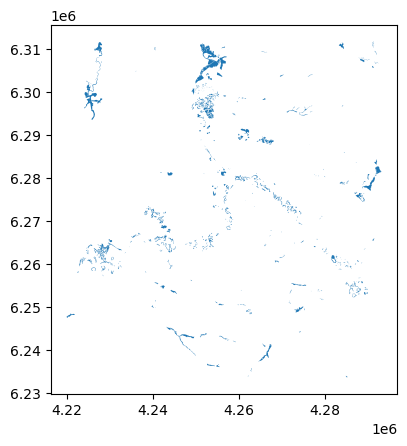

In [110]:
# Read and display data
warzone_wetlands = gpd.read_file(warzone_wetlands_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_wetlands.crs)
warzone_wetlands.plot()

In [111]:
warzone_wetlands.columns

Index(['id', '@id', 'area', 'leaf_cycle', 'leaf_type', 'natural', 'wetland',
       'geometry'],
      dtype='object')

In [112]:
warzone_wetlands.iloc[0,:].values

array(['way/35639520', 'way/35639520', None, None, None, 'wetland',
       'marsh',
       <POLYGON ((4291149.063 6265518.413, 4291182.504 6265418.091, 4291244.609 626...>],
      dtype=object)

In [113]:
warzone_wetlands.isna().any()

id            False
@id           False
area           True
leaf_cycle     True
leaf_type      True
natural       False
wetland        True
geometry      False
dtype: bool

In [114]:
warzone_wetlands.loc[:,'wetland'].value_counts(dropna=False)

wetland
swamp         360
reedbed       227
None          191
marsh          69
wet_meadow     18
fen            10
bog             2
Name: count, dtype: int64

In [115]:
# Replace None values in 'wetland' column with 'wetland' as their new value
warzone_wetlands['wetland'] = warzone_wetlands['wetland'].fillna('wetland')

In [116]:
# Filter needed columns
warzone_wetlands = warzone_wetlands.loc[:,['id', '@id','wetland','geometry']]
warzone_wetlands.head(1)

,id,@id,wetland,geometry
0,way/35639520,way/35639520,marsh,"POLYGON ((4291149.063 6265518.413, 4291182.504..."


In [117]:
warzone_wetlands.isna().any()

id          False
@id         False
wetland     False
geometry    False
dtype: bool

In [118]:
# Unpivot GeoDataFrame
warzone_wetlands_unpivot = warzone_wetlands.melt(
    id_vars=['id', '@id','geometry'],
    value_vars='wetland', 
    value_name='sub_category', 
    var_name='category',
    ignore_index=True
)

warzone_wetlands_unpivot.head(10)

,id,@id,geometry,category,sub_category
0,way/35639520,way/35639520,"POLYGON ((4291149.063 6265518.413, 4291182.504...",wetland,marsh
1,way/112684020,way/112684020,"POLYGON ((4269915.383 6267402.336, 4269920.069...",wetland,marsh
2,way/112927487,way/112927487,"POLYGON ((4274699.471 6265212.536, 4274709.757...",wetland,reedbed
3,way/182211395,way/182211395,"POLYGON ((4222634.577 6258290.850, 4222596.417...",wetland,wetland
4,way/182401547,way/182401547,"POLYGON ((4231936.067 6260307.302, 4231973.648...",wetland,wetland
5,way/220263530,way/220263530,"POLYGON ((4285077.899 6260555.796, 4285084.533...",wetland,marsh
6,way/220263533,way/220263533,"POLYGON ((4283792.749 6260971.309, 4283800.819...",wetland,marsh
7,way/220263534,way/220263534,"POLYGON ((4283147.541 6260282.266, 4283200.651...",wetland,marsh
8,way/220263535,way/220263535,"POLYGON ((4285236.473 6260521.850, 4285229.505...",wetland,marsh
9,way/220263536,way/220263536,"POLYGON ((4284572.709 6261145.963, 4284581.147...",wetland,marsh


<Axes: >

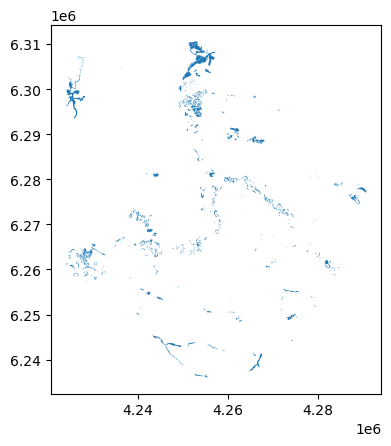

In [119]:
warzone_wetlands_unpivot.clip(kreminna_aoi).plot()

In [120]:
# Export clipped wetlands
warzone_wetlands_unpivot.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-wetlands.geojson', driver='GeoJSON')

#### Rivers, streams

__Overpass Turbo:__

```
[out:json][timeout:60];

way["waterway"](48.758341,37.909804,49.211731,38.55444);

out geom;

```

In [121]:
# Store file path
warzone_rivers_file = os.path.join('assets','osint','kreminna-rivers.geojson')

EPSG:3857


<Axes: >

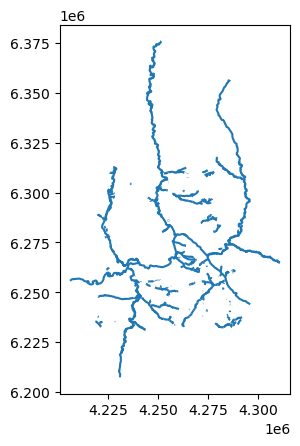

In [122]:
# Read and display data
warzone_rivers = gpd.read_file(warzone_rivers_file).to_crs(projCRS).dropna(how='all').reset_index(drop=True)
print(warzone_rivers.crs)
warzone_rivers.plot()

In [123]:
warzone_rivers.columns

Index(['id', '@id', 'alt_name:cs', 'boat', 'est_width', 'int_name',
       'intermittent', 'layer', 'loc_name', 'lock', 'material', 'name',
       'name:be', 'name:bg', 'name:cs', 'name:de', 'name:el', 'name:en',
       'name:he', 'name:hu', 'name:hy', 'name:ka', 'name:pl', 'name:ro',
       'name:ru', 'name:uk', 'name:zh', 'old_name', 'source', 'tunnel',
       'waterway', 'width', 'wikidata', 'wikipedia', 'geometry'],
      dtype='object')

In [124]:
warzone_rivers.iloc[0,:].values

array(['way/1058339134', 'way/1058339134', None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, 'dam', None, None, None,
       <POLYGON ((4238509.204 6261634.843, 4238492.339 6261634.115, 4238496.536 626...>],
      dtype=object)

In [125]:
warzone_rivers.isna().any()

id              False
@id             False
alt_name:cs      True
boat             True
est_width        True
int_name         True
intermittent     True
layer            True
loc_name         True
lock             True
material         True
name             True
name:be          True
name:bg          True
name:cs          True
name:de          True
name:el          True
name:en          True
name:he          True
name:hu          True
name:hy          True
name:ka          True
name:pl          True
name:ro          True
name:ru          True
name:uk          True
name:zh          True
old_name         True
source           True
tunnel           True
waterway        False
width            True
wikidata         True
wikipedia        True
geometry        False
dtype: bool

In [126]:
warzone_rivers.loc[:,'waterway'].value_counts(dropna=False)

waterway
stream    287
drain     123
weir       87
river      21
canal      10
dam         5
Name: count, dtype: int64

In [127]:
warzone_rivers.loc[:,'width'].value_counts(dropna=False)

width
None    530
1         2
2         1
Name: count, dtype: int64

In [128]:
# Replace None values in 'waterway' column with 'waterway' as their new value
warzone_rivers['waterway'] = warzone_rivers['waterway'].fillna('waterway')

In [129]:
# Filter needed columns
warzone_rivers = warzone_rivers.loc[:,['id', '@id','waterway','geometry']]
warzone_rivers.head(1)

,id,@id,waterway,geometry
0,way/1058339134,way/1058339134,dam,"POLYGON ((4238509.204 6261634.843, 4238492.339..."


In [130]:
# Unpivot GeoDataFrame
warzone_rivers_unpivot = warzone_rivers.melt(
    id_vars=['id', '@id','geometry'],
    value_vars='waterway', 
    value_name='sub_category', 
    var_name='category', 
    ignore_index=True
)

warzone_rivers_unpivot.sample(10)

,id,@id,geometry,category,sub_category
527,way/1144676512,way/1144676512,"LINESTRING (4239429.738 6255278.992, 4239446.4...",waterway,stream
6,way/140095562,way/140095562,"LINESTRING (4252444.968 6280740.885, 4252491.5...",waterway,stream
220,way/575150694,way/575150694,"LINESTRING (4275404.179 6249812.830, 4275400.0...",waterway,stream
436,way/904450779,way/904450779,"LINESTRING (4267188.200 6298934.140, 4267190.5...",waterway,weir
307,way/710713928,way/710713928,"LINESTRING (4274385.339 6254907.991, 4274421.2...",waterway,drain
161,way/483306007,way/483306007,"LINESTRING (4247570.878 6296010.419, 4247600.8...",waterway,stream
293,way/687819864,way/687819864,"LINESTRING (4266875.025 6267801.689, 4266854.2...",waterway,weir
76,way/376848672,way/376848672,"LINESTRING (4223986.419 6281944.731, 4223963.7...",waterway,drain
136,way/461850186,way/461850186,"LINESTRING (4287442.692 6260662.853, 4287491.3...",waterway,drain
349,way/771334119,way/771334119,"LINESTRING (4254158.042 6251397.427, 4254131.4...",waterway,stream


<Axes: >

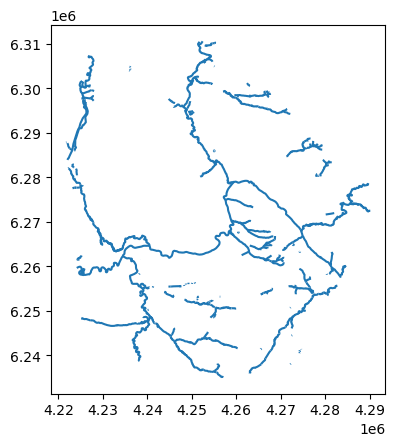

In [131]:
warzone_rivers_unpivot.clip(kreminna_aoi).plot()

In [132]:
# Export clipped rivers
warzone_rivers_unpivot.clip(kreminna_aoi).to_crs(geoCRS).to_file('kreminna-clipped-rivers.geojson', driver='GeoJSON')